## Regional SAT anomalies calculation then calculate the trend

In [1]:
# In[1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# %%
# define function
import src.SAT_function as data_process
import src.Data_Preprocess as preprocess

In [2]:
# import src.slurm_cluster as scluster
# client, scluster = scluster.init_dask_slurm_cluster(scale=2,cores=10, memory="200GB")

In [3]:
def func_mk(x):
    """
    Mann-Kendall test for trend
    """
    results = data_process.mk_test(x)
    slope = results[0]
    p_val = results[1]
    return slope, p_val

In [4]:
# load data
dir_HadCRUT5 = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Supp_Figure1/'
HadCRUT5 = xr.open_dataset(dir_HadCRUT5 + 'tas_HadCRUT5_annual_anomalies_processed.nc')

dir1 ='/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Supplementary/S1/data_revise/'
HadCRUT5_forced = xr.open_mfdataset(dir1 + 'HadCRUT_Forced_signal.nc',chunks={'lat':10,'lon':10})
HadCRUT5_internal = xr.open_mfdataset(dir1 + 'HadCRUT_residual.nc',chunks={'lat':10,'lon':10})

In [5]:
HadCRUT5

<xarray.Dataset>
Dimensions:                        (year: 173, lat: 90, lon: 180)
Coordinates:
  * year                           (year) int64 1850 1851 1852 ... 2021 2022
  * lat                            (lat) float64 -89.0 -87.0 -85.0 ... 87.0 89.0
  * lon                            (lon) float64 0.0 2.0 4.0 ... 356.0 358.0
Data variables:
    __xarray_dataarray_variable__  (year, lat, lon) float64 ...

In [6]:
HadCRUT5 = HadCRUT5.rename({'__xarray_dataarray_variable__':'tas'})
HadCRUT5_forced = HadCRUT5_forced.rename({'__xarray_dataarray_variable__':'tas'})
HadCRUT5_internal = HadCRUT5_internal.rename({'__xarray_dataarray_variable__':'tas'})

In [7]:
HadCRUT5

<xarray.Dataset>
Dimensions:  (year: 173, lat: 90, lon: 180)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    tas      (year, lat, lon) float64 ...

### Calculate the trend end year fix to 2022, start with 73 year length and decrease length of trend every one year, the minimum trend length is 10yr 

In [8]:
temp_data = HadCRUT5.tas
temp_data_forced = HadCRUT5_forced.tas
temp_data_internal = HadCRUT5_internal.tas

In [9]:
temp_data

<xarray.DataArray 'tas' (year: 173, lat: 90, lon: 180)>
[2802600 values with dtype=float64]
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [10]:
# flip the longitude to -180 to 180
temp_data_adj = preprocess.convert_longitude(temp_data)
temp_data_forced_adj = preprocess.convert_longitude(temp_data_forced)
temp_data_internal_adj = preprocess.convert_longitude(temp_data_internal)

In [11]:
temp_data_adj

<xarray.DataArray 'tas' (year: 173, lat: 90, lon: 180)>
[2802600 values with dtype=float64]
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0

In [12]:
type(temp_data_adj)

xarray.core.dataarray.DataArray

In [13]:
temp_data_forced_adj

<xarray.DataArray 'tas' (year: 173, lat: 90, lon: 180)>
dask.array<getitem, shape=(173, 90, 180), dtype=float64, chunksize=(173, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
    height   float64 ...
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0

### Regional anomalies calculation

In [14]:
def plot_trend(temp_data, lats, lons, levels=None, extend=None, cmap=None, 
                                 title="", ax=None, show_xticks=False, show_yticks=False):
    """
    Plot the trend spatial pattern using Robinson projection with significance overlaid.

    Parameters:
    - temp_data: 2D numpy array with the trend values.
    - lats, lons: 1D arrays of latitudes and longitudes.
    - p_values: 2D array with p-values for each grid point.
    - GMST_p_values: 2D array with GMST p-values for each grid point.
    - title: Title for the plot.
    - ax: Existing axis to plot on. If None, a new axis will be created.
    - show_xticks, show_yticks: Boolean flags to show x and y axis ticks.
    
    Returns:
    - contour_obj: The contour object from the plot.
    """
    # Plotting
    contour_obj = ax.contourf(lons, lats, temp_data, levels=levels, extend=extend, cmap=cmap, transform=ccrs.PlateCarree())

    ax.coastlines(resolution='110m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      color='gray', alpha=0.35, linestyle='--')

    # Disable labels on the top and right of the plot
    gl.top_labels = False
    gl.right_labels = False

    # Enable labels on the bottom and left of the plot
    gl.bottom_labels = show_xticks
    gl.left_labels = show_yticks
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}
    
    if show_xticks:
        gl.bottom_labels = True
    if show_yticks:
        gl.left_labels = True
    
    # ax.set_title(title, loc='center', fontsize=18, pad=5.0)

    return contour_obj
# %%
plt.rcParams['figure.figsize'] = (8, 10)
plt.rcParams['font.size'] = 16
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.right'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['savefig.transparent'] = True

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.util as cutil
import seaborn as sns
import matplotlib.colors as mcolors
import palettable

In [15]:
lat = temp_data_adj.lat
lon = temp_data_adj.lon

In [16]:
temp_data_adj

<xarray.DataArray 'tas' (year: 173, lat: 90, lon: 180)>
[2802600 values with dtype=float64]
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0

In [17]:
# Define the trapezoid region
# Southeast Pacific coordinates
lat5 = -25
lat6 = 0
lon5 = -160
lon6 = -80
lon7 = -110

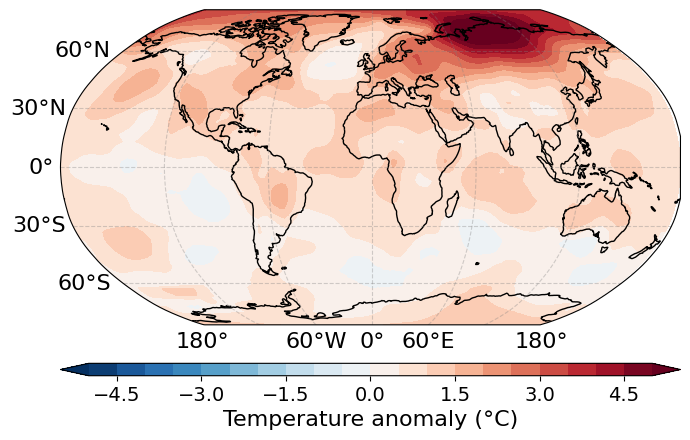

In [19]:
da_plot = temp_data_adj.sel(year=2020)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()})

contour_obj =  plot_trend(da_plot, da_plot.lat, da_plot.lon, levels=np.arange(-5, 5.5, 0.5), extend='both', cmap='RdBu_r',
                                    title="SEP region SAT anomaly 2020", ax=ax, show_xticks=True, show_yticks=True)

# colorbar
cbar = plt.colorbar(contour_obj, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Temperature anomaly (°C)')
cbar.ax.tick_params(labelsize=14)

plt.show()

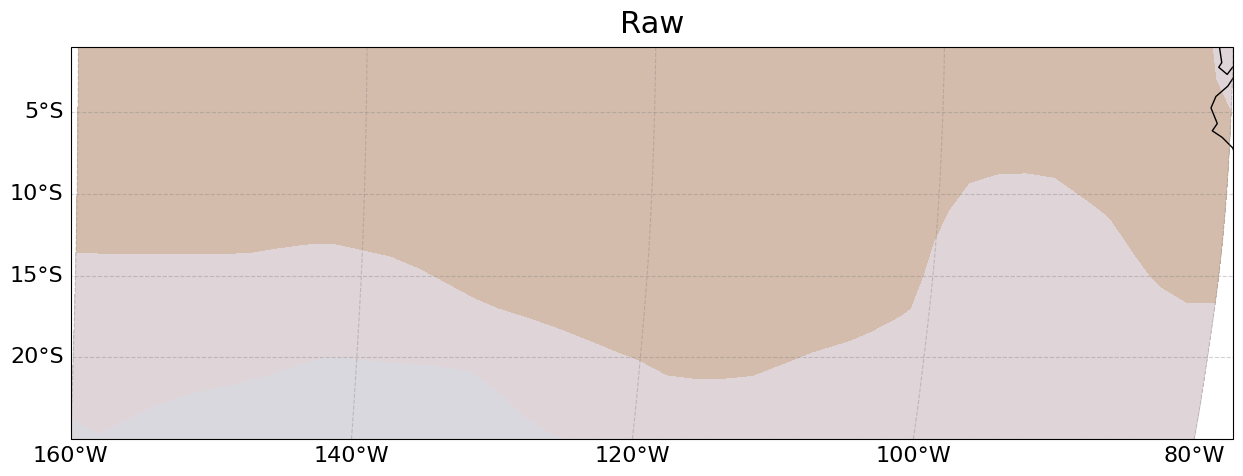

In [23]:
# select the region with mask
temp_da_array_sep = temp_data_adj.sel(lat=slice(lat5, lat6), lon=slice(lon5, lon6))

plot_data = temp_da_array_sep.sel(year=1993)
levels = np.arange(-4.5, 5.0, 0.5)
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(1, 1, figure=fig, hspace=0.01, wspace=0.01)

ax = fig.add_subplot(gs[0,0], projection=ccrs.Robinson(180))
# temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(temp_da_array_sep, coord=lon)
# pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(pvalue_annual_da['40yr'], coord=lon)
contour_obj = plot_trend(plot_data, plot_data.lat, plot_data.lon, levels=levels,extend='both', cmap='twilight_shifted',
            title=" ", ax=ax, show_xticks=True, show_yticks=True)
ax.set_title('Raw', fontsize=22, pad=10.0)

plt.show()

In [27]:
temp_da_array_sep

<xarray.DataArray 'tas' (year: 173, lat: 13, lon: 41)>
[92209 values with dtype=float64]
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022
  * lat      (lat) float64 -25.0 -23.0 -21.0 -19.0 -17.0 ... -7.0 -5.0 -3.0 -1.0
  * lon      (lon) float64 -160.0 -158.0 -156.0 -154.0 ... -84.0 -82.0 -80.0

[-25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.  -5.  -3.  -1.]
[-160. -158. -156. -154. -152. -150. -148. -146. -144. -142. -140. -138.
 -136. -134. -132. -130. -128. -126. -124. -122. -120. -118. -116. -114.
 -112. -110. -108. -106. -104. -102. -100.  -98.  -96.  -94.  -92.  -90.
  -88.  -86.  -84.  -82.  -80.]


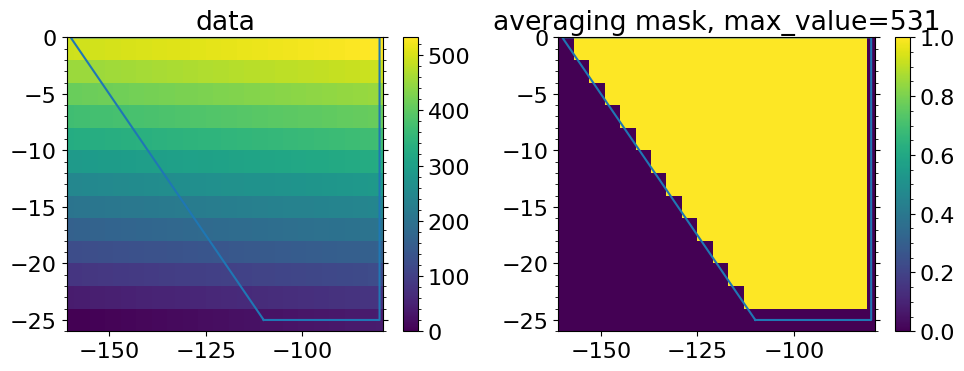

In [24]:
import src.Polygon_region as poly
# %%
# define the polygon region 

if __name__ == '__main__':
    import matplotlib.pyplot as pl
    pl.close('all')

    # Dummy data.
    lats = temp_da_array_sep.lat.values
    lons = temp_da_array_sep.lon.values
    print(lats)
    print(lons)
    
    data = np.arange(lats.size*lons.size).reshape((lats.size, lons.size))
    
    # Bounding box.
    poly_x = np.array([-110, -160, -80, -80, -110])  # Longitude values
    poly_y = np.array([-25, 0, 0, -25, -25])         # Latitude values
    
    # Generate mask for calculating statistics.
    mask = np.zeros_like(data, dtype=bool)
    poly.get_mask(mask, lons, lats, poly_x, poly_y)
    
    # Calculate statistics.
    max_val = data[mask].max()
    
    # Plot data and mask.
    pl.figure(figsize=(10,4))
    pl.subplot(121)
    pl.title('data')
    pl.pcolormesh(lons, lats, data)
    pl.plot(poly_x, poly_y)
    pl.colorbar()
    
    pl.subplot(122)
    pl.title('averaging mask, max_value={}'.format(max_val))
    pl.pcolormesh(lons, lats, mask)
    pl.plot(poly_x, poly_y)
    pl.colorbar()
    
    pl.tight_layout()

In [29]:
mask.shape

(1, 1, 13, 41)

In [33]:
temp_forced_sep = temp_data_forced_adj.sel(lat=slice(lat5, lat6), lon=slice(lon5, lon6))
temp_internal_sep = temp_data_internal_adj.sel(lat=slice(lat5, lat6), lon=slice(lon5, lon6))

In [34]:
temp_data_forced_SEP = temp_forced_sep.where(mask[0,0,:,:])
temp_data_internal_SEP = temp_internal_sep.where(mask[0,0,:,:])

In [35]:
temp_da_SoutheastPacific_forced_mean = temp_data_forced_SEP.mean(dim=['lat','lon'],skipna=True)
temp_da_SoutheastPacific_internal_mean = temp_data_internal_SEP.mean(dim=['lat','lon'],skipna=True)

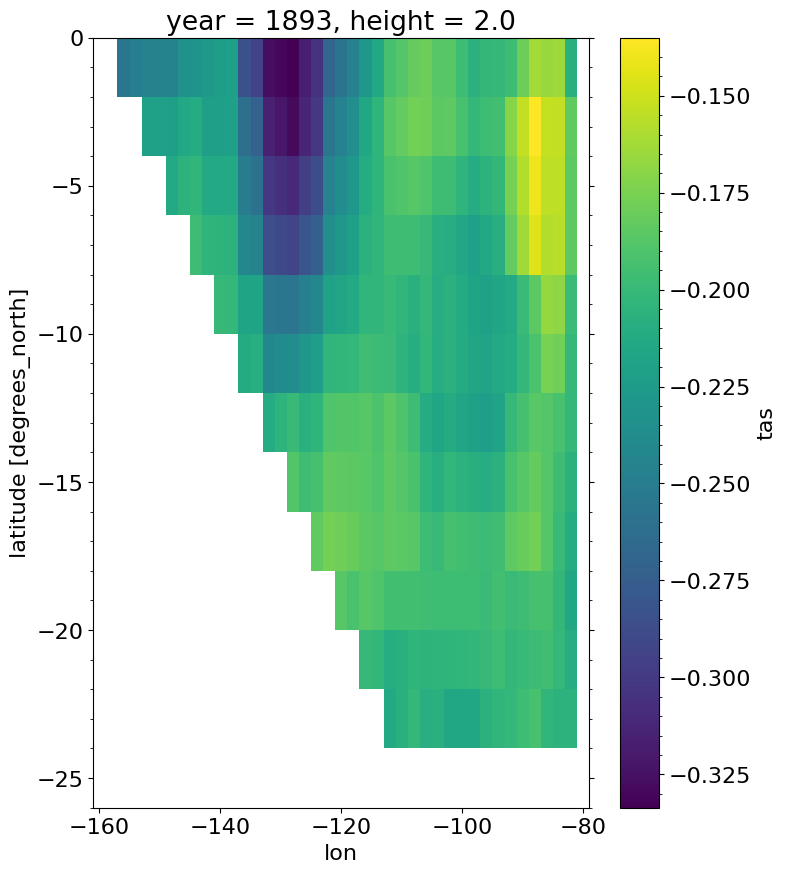

In [37]:
 temp_data_forced_SEP.isel(year=43).plot()


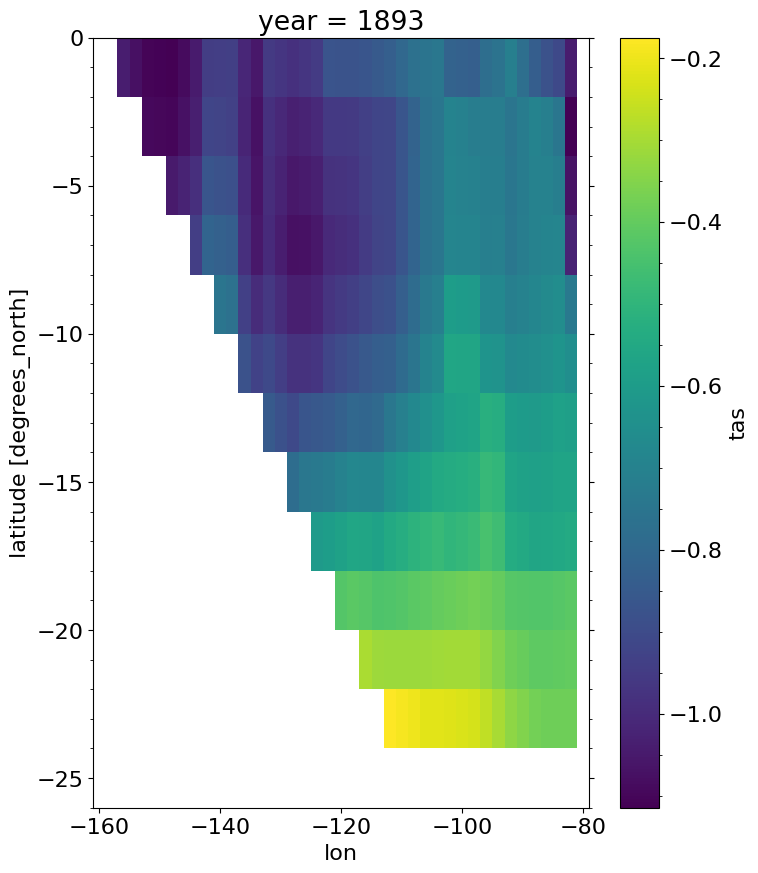

In [31]:
# select the region with mask
# mask = mask[None,:,:]
# %%
temp_da_SoutheastPacific = temp_da_array_sep.where(mask[0,0,:,:])
# %%
# plot the region
temp_da_SoutheastPacific.isel(year=43).plot()
# %%
temp_da_SoutheastPacific_mean = temp_da_SoutheastPacific.mean(dim=['lat', 'lon'], skipna=True)

In [32]:
temp_da_SoutheastPacific_mean

<xarray.DataArray 'tas' (year: 173)>
array([-3.89825825e-01, -2.25393974e-01, -2.37682256e-01, -2.43778128e-01,
       -4.21340296e-01, -1.48017008e-01, -4.89695101e-01, -4.31709232e-01,
       -2.16814410e-01, -4.45184273e-01, -3.84663066e-01, -2.60164449e-01,
       -4.21904331e-01, -4.93740668e-02,  1.20288095e-01,  0.00000000e+00,
       -7.78129297e-02, -8.99727310e-03,  5.61961941e-02, -6.50902066e-01,
       -5.82813649e-01, -2.73031972e-01, -6.45037395e-01, -8.18414187e-01,
       -8.73932804e-01, -5.21041586e-01, -3.95412209e-01,  1.14251676e+00,
        6.17817377e-01, -1.02656560e-01,  2.11386293e-02, -2.87161432e-02,
       -2.98405906e-01, -2.36139023e-01, -8.47767544e-02, -1.41395705e-01,
       -5.07677305e-01, -3.04511750e-01,  7.20125977e-01,  2.45683914e-02,
       -5.98451221e-01, -1.07542600e-01, -8.13268974e-01, -7.23842836e-01,
       -4.40592560e-01, -2.92978914e-02,  4.15195031e-01,  2.55791990e-01,
       -4.30319095e-01,  4.04853082e-01,  3.98927333e-01, -5.03945193e-02,
        2.98753211e-01, -5.61848693e-01, -1.88701128e-01,  5.04479494e-01,
       -1.40054318e-01, -3.18498377e-01, -6.44578835e-01, -8.81308545e-01,
       -8.88708492e-01, -4.72622970e-01, -1.57707316e-01, -6.49208187e-02,
       -2.16818234e-02, -1.95456988e-01, -9.57321707e-01, -9.69522503e-01,
       -2.26708017e-01,  1.55193821e-02, -2.07614152e-01, -4.65362035e-01,
       -6.60791091e-01, -2.98227652e-01, -8.00271099e-01, -4.71716188e-02,
        1.30011161e-01, -2.34185517e-01, -2.93488105e-01, -2.28431325e-01,
...
       -2.25724385e-01, -1.54689661e-01, -1.50551488e-01, -2.25849552e-01,
       -5.99898541e-01,  1.42560094e-01,  2.39542207e-01,  3.11644748e-01,
       -6.95812692e-01, -8.91282673e-01, -6.92574358e-01,  4.72229527e-01,
        2.78783644e-01, -5.01654540e-02,  5.12090059e-02, -2.64733299e-01,
       -4.97820963e-01,  5.50333908e-02, -6.25505824e-01,  3.93341923e-01,
       -2.78809610e-01, -7.23566365e-01, -3.45466522e-01,  3.64001615e-01,
       -4.20174091e-01, -7.93476161e-01,  6.98175114e-01, -3.34538532e-01,
       -6.11778185e-01, -7.13150763e-01,  1.58158585e-02,  3.39673049e-01,
       -5.66779684e-02,  5.44719506e-01,  4.00308413e-01,  5.07313290e-02,
        6.47180215e-01,  1.19336472e+00,  1.75574064e-01, -2.54937686e-01,
        2.38335621e-01,  1.00086662e+00, -1.62605953e-01, -1.52263295e-01,
        1.18383777e-01,  4.00992503e-01,  5.98544221e-01,  5.98703252e-01,
        3.78375633e-01,  1.55000422e-01, -1.24057617e-02,  1.30388195e+00,
        9.44857115e-01, -1.98135416e-01, -8.70199148e-03,  1.83004757e-01,
        3.74114008e-01,  3.27064256e-01,  3.84389441e-01,  2.69640862e-01,
        5.56973074e-01, -9.51418970e-02,  1.13958505e-01,  6.03374768e-01,
       -2.62785434e-01, -2.87608477e-01,  5.55182907e-01,  1.22270267e-01,
        2.31728563e-01,  9.81765761e-01,  9.69002185e-01,  5.85381686e-01,
        1.57089121e-01,  4.31872844e-01,  3.76095061e-02, -1.35203371e-01,
       -4.87175412e-01])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022

In [38]:
dir_out = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Figure4/data/'

temp_da_SoutheastPacific_mean.to_netcdf(dir_out + '1850_2022_Raw_SoutheastPacific_mean.nc')
temp_da_SoutheastPacific_forced_mean.to_netcdf(dir_out + '1850_2022_Forced_SoutheastPacific_mean.nc')
temp_da_SoutheastPacific_internal_mean.to_netcdf(dir_out + '1850_2022_Internal_SoutheastPacific_mean.nc')

### Segments definitions

In [39]:
import pandas as pd
import numpy as np

start_year = 1950
end_year = 2022
min_length = 10

In [40]:
years = np.arange(start_year, end_year + 1)

# Prepare a dictionary to hold the trend DataArrays for each period
temp_data_segments = {}

for begin_year in range(start_year, end_year - min_length+2):
    # Select the data from the start year to the last year
    time_slice = temp_da_SoutheastPacific_mean.sel(year=slice(begin_year, end_year))
    
    temp_data_segments[begin_year] = time_slice

In [41]:
temp_data_forced_segments = {}
temp_data_internal_segments = {}

for begin_year in range(start_year, end_year - min_length+2):
    # Select the data from the start year to the last year
    time_slice = temp_da_SoutheastPacific_forced_mean.sel(year=slice(begin_year, end_year))
    
    temp_data_forced_segments[begin_year] = time_slice

for begin_year in range(start_year, end_year - min_length+2):
    # Select the data from the start year to the last year
    time_slice = temp_da_SoutheastPacific_internal_mean.sel(year=slice(begin_year, end_year))
    
    temp_data_internal_segments[begin_year] = time_slice

In [42]:
temp_data_segments

{1950: <xarray.DataArray 'tas' (year: 73)>
 array([-0.59989854,  0.14256009,  0.23954221,  0.31164475, -0.69581269,
        -0.89128267, -0.69257436,  0.47222953,  0.27878364, -0.05016545,
         0.05120901, -0.2647333 , -0.49782096,  0.05503339, -0.62550582,
         0.39334192, -0.27880961, -0.72356636, -0.34546652,  0.36400161,
        -0.42017409, -0.79347616,  0.69817511, -0.33453853, -0.61177818,
        -0.71315076,  0.01581586,  0.33967305, -0.05667797,  0.54471951,
         0.40030841,  0.05073133,  0.64718022,  1.19336472,  0.17557406,
        -0.25493769,  0.23833562,  1.00086662, -0.16260595, -0.1522633 ,
         0.11838378,  0.4009925 ,  0.59854422,  0.59870325,  0.37837563,
         0.15500042, -0.01240576,  1.30388195,  0.94485712, -0.19813542,
        -0.00870199,  0.18300476,  0.37411401,  0.32706426,  0.38438944,
         0.26964086,  0.55697307, -0.0951419 ,  0.11395851,  0.60337477,
        -0.26278543, -0.28760848,  0.55518291,  0.12227027,  0.23172856,
        

In [43]:
len(temp_data_segments.keys())

64

In [44]:
# calculate the trend for each segment
trends = {}

for begin_year in temp_data_segments.keys():
    temp_data = temp_data_segments[begin_year]
    temp_data_forced = temp_data_forced_segments[begin_year]
    temp_data_internal = temp_data_internal_segments[begin_year]
    
    # Calculate the trend for each segment
    trends[begin_year] = {}
    trends[begin_year]['raw'] = data_process.mk_test(temp_data,a=0.05)[0]*10.0
    trends[begin_year]['forced'] = data_process.mk_test(temp_data_forced,a=0.05)[0]*10.0
    trends[begin_year]['internal'] = data_process.mk_test(temp_data_internal,a=0.05)[0]*10.0

In [45]:
trends

{1950: {'raw': 0.08078440899702968,
  'forced': 0.08437219171199058,
  'internal': 0.005181517011152794},
 1951: {'raw': 0.07470448328554853,
  'forced': 0.0870207474416759,
  'internal': -0.0021924900893699854},
 1952: {'raw': 0.07959054148534665,
  'forced': 0.08955724821735017,
  'internal': -8.518668257348175e-05},
 1953: {'raw': 0.08752586319712222,
  'forced': 0.09196727099036797,
  'internal': 0.005854285447902674},
 1954: {'raw': 0.09683774819268104,
  'forced': 0.09382209027391668,
  'internal': 0.011276499702772374},
 1955: {'raw': 0.08772998670372806,
  'forced': 0.09542917783705152,
  'internal': 0.0009708147860370489},
 1956: {'raw': 0.07600085122615713,
  'forced': 0.09641571177731767,
  'internal': -0.010215470189730394},
 1957: {'raw': 0.06687555921583206,
  'forced': 0.0975071052258614,
  'internal': -0.020983372145421446},
 1958: {'raw': 0.07544610619708303,
  'forced': 0.09867203942911311,
  'internal': -0.013123369252126888},
 1959: {'raw': 0.0821111650634854,
  'fo

In [46]:
# transform the dictionary to dataframe
trends_df = pd.DataFrame(trends).T
trends_df

# for interval, data in temp_annual_np.items():
#     temp_annual_da[interval] = xr.DataArray(data, dims=["lat", "lon"], coords={"lat": temp_data[interval].lat, "lon": temp_data[interval].lon})
# for interval, data in pvalue_annual_np.items():
#     pvalue_annual_da[interval] = xr.DataArray(data, dims=["lat", "lon"], coords={"lat": temp_data[interval].lat, "lon": temp_data[interval].lon})

,raw,forced,internal
1950,0.080784,0.084372,0.005182
1951,0.074704,0.087021,-0.002192
1952,0.079591,0.089557,-0.000085
1953,0.087526,0.091967,0.005854
1954,0.096838,0.093822,0.011276
...,...,...,...
2009,-0.248230,0.139503,-0.393781
2010,-0.186795,0.142873,-0.330753
2011,-0.622182,0.142062,-0.754801
2012,-0.898630,0.141323,-1.042350


In [47]:
# data frame to dataset
trends_ds = trends_df.to_xarray()

In [48]:
trends_ds

<xarray.Dataset>
Dimensions:   (index: 64)
Coordinates:
  * index     (index) int64 1950 1951 1952 1953 1954 ... 2010 2011 2012 2013
Data variables:
    raw       (index) float64 0.08078 0.0747 0.07959 ... -0.6222 -0.8986 -1.375
    forced    (index) float64 0.08437 0.08702 0.08956 ... 0.1421 0.1413 0.1377
    internal  (index) float64 0.005182 -0.002192 -8.519e-05 ... -1.042 -1.492

In [49]:
# export the trend to the netcdf file
trends_ds.to_netcdf(dir_out + 'SoutheastPacific_trend_variations.nc')

In [50]:
dirin = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Figure4/data/'
arctic_unforced_lower = xr.open_dataset(f'{dirin}internal_SEP_trend_lower_percentile.nc')
arctic_unforced_upper = xr.open_dataset(f'{dirin}internal_SEP_trend_upper_percentile.nc')

In [51]:
arctic_unforced_lower

<xarray.Dataset>
Dimensions:                        (time: 64)
Coordinates:
  * time                           (time) int64 10 11 12 13 14 ... 70 71 72 73
Data variables:
    __xarray_dataarray_variable__  (time) float64 ...

In [52]:
arctic_unforced_lower = arctic_unforced_lower.rename_vars({'__xarray_dataarray_variable__':'trend'})
arctic_unforced_upper = arctic_unforced_upper.rename_vars({'__xarray_dataarray_variable__':'trend'})

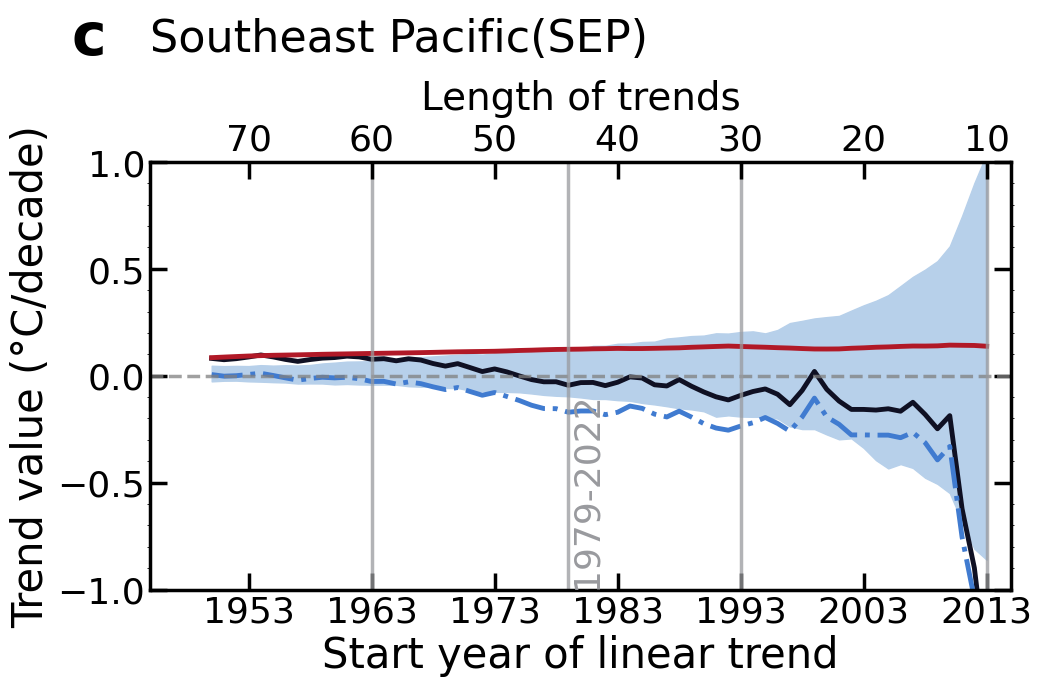

In [ ]:
import seaborn as sns
from matplotlib.lines import Line2D

# sns.set_theme(style="whitegrid")
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname': 'Arial', 'size': '20', 'color': 'black', 'weight': 'normal',
                'verticalalignment': 'bottom'}  # Bottom vertical alignment for more space
axis_font = {'fontname': 'Arial', 'size': '20'}

# Create the plot
fig = plt.figure(figsize=(25, 15))
gs = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.7)

ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])
# ax3 = plt.subplot(gs[1, 0])
# ax4 = plt.subplot(gs[1, 1])

# define rgb colors for the outlines
# colors = [(32,120,180), #blue
#           (106,61,154), #purple
#           (173,23,88), #magenta
#           (255,127,0), #orange
#           (226,26,27),#red
#           (49,160,45) #green
#          ]
# colors_set = [(r / 255, g / 255, b / 255) for r, g, b in colors]
colors = ['#0F1023','#B11927', '#407BD0', '#B7D0EA']
line_widths = [5.5, 5.5, 5.5, 5.5, 1.5, 1.5, 1.5]
titles = ['Southeast Pacific(SEP)', 'Southern Ocean Pacific sector(SOP)']
linestyles = ['-', '-', '-.', ':']

vars = ['raw', 'forced', 'internal']
# We use a loop to simulate multiple lines for each category
for i, var in enumerate(vars):
    # Plot the forced trends for the EU region
    sns.lineplot(x=np.arange(1950,2014), y=trends_ds[var].values, color=colors[i], linestyle=linestyles[i], linewidth=3.5, ax=ax1)

ax1.fill_between(np.arange(1950,2014), arctic_unforced_lower.trend.values[::-1], arctic_unforced_upper.trend.values[::-1], color=colors[3])

ax1.set_xlim([1945, 2015])
ax1.set_ylim([-1.0, 1.0])
ax1.set_xticks([1953, 1963, 1973, 1983, 1993, 2003, 2013])
ax1.set_xticklabels(['1953', '1963', '1973', '1983', '1993', '2003', '2013'])
ax1_upper = ax1.twiny()
ax1_upper.invert_xaxis()
ax1_upper.set_xlim([78,8])
ax1_upper.set_xlabel('Length of trends', fontsize=28, labelpad=10)
ax1_upper.set_xticks([70, 60, 50, 40, 30, 20, 10])
ax1_upper.set_xticklabels(['70', '60', '50', '40', '30', '20', '10'])
ax1.spines['top'].set_linewidth(2.5)
ax1.spines['right'].set_linewidth(2.5)
ax1.spines['bottom'].set_linewidth(2.5)
ax1.spines['left'].set_linewidth(2.5)
ax1_upper.tick_params(axis='x', labelsize=26)
ax1_upper.tick_params(axis='x', which='major', length=12, width=2.5, direction='in')
ax1.axhline(y=0, color='grey', linestyle='--', linewidth=2.5, alpha=0.75)
ax1.set_ylabel('Trend value (°C/decade)', fontsize=30)
ax1.set_xlabel('Start year of linear trend', fontsize=30)
ax1.set_title(titles[0], loc='left',fontsize=32,pad=20)
ax1.tick_params(axis='x', which='major', length=12, labelsize=26, width=2.5, direction='in')
ax1.tick_params(axis='y', which='major', length=12, labelsize=26, width=2.5, direction='in')
ax1.axvline(x=2013, color='#999A9E', linestyle='-', linewidth=2.5, alpha=0.75)
ax1.axvline(x=1993, color='#999A9E', linestyle='-', linewidth=2.5, alpha=0.75)
ax1.axvline(x=1979, color='#999A9E', linestyle='-', linewidth=2.5, alpha=0.75)
ax1.axvline(x=1963, color='#999A9E', linestyle='-', linewidth=2.5, alpha=0.75)
ax1.text(1979.1, -0.96, '1979-2022', fontsize=26, rotation=90, color='#999A9E')
# ax1.text(1940, 1.58, 'c', fontsize=42, ha='center', va='center', fontweight='bold')
# custom_lines = [Line2D([0], [0], color=colors[0], lw=3.5),
#                 Line2D([0], [0], color=colors[1], lw=3.5),
#                 Line2D([0], [0], color=colors[2], lw=3.5)]
# leg2 = ax1.legend(custom_lines, ['total', 'human forced', 'internal variability'], 
#                   loc='lower left', fontsize=26)
# ax1.add_artist(leg2)
plt.savefig('./SEP_trend_variations.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# # 3rd calculate the internal trend
# internal_temp_dict = {}
# internal_pvalue_dict = {}

# for i in range(len(variable_name)):
#     data_var = internal_dict[variable_name[i]]['tas']
    
#     slope, p_values = xr.apply_ufunc(
#         func_mk,
#         data_var,
#         input_core_dims=[["year"]],
#         output_core_dims=[[], []],
#         vectorize=True,
#         dask="parallelized",
#         output_dtypes=[float, float],
#         dask_gufunc_kwargs={'allow_rechunk': True}
#     )
#     internal_temp_dict[variable_name[i]] = slope
#     internal_pvalue_dict[variable_name[i]] = p_values

# internal_temp_annual_np = {}
# internal_pvalue_annual_np = {}

# for i in range(len(variable_name)):
#     internal_temp_annual_np[variable_name[i]] = internal_temp_dict[variable_name[i]].values
#     internal_pvalue_annual_np[variable_name[i]] = internal_pvalue_dict[variable_name[i]].values
    
# internal_temp_annual_da = {}
# internal_pvalue_annual_da = {}

# for interval, data in internal_temp_annual_np.items():
#     internal_temp_annual_da[interval] = xr.DataArray(data, dims=["lat", "lon"], coords={"lat": data_dict[interval].lat, "lon": data_dict[interval].lon})
# for interval, data in internal_pvalue_annual_np.items():
#     internal_pvalue_annual_da[interval] = xr.DataArray(data, dims=["lat", "lon"], coords={"lat": data_dict[interval].lat, "lon": data_dict[interval].lon})


### Plotting with the Robinson Projections

In [ ]:
# define an asymmetric colormap
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.util as cutil
import seaborn as sns
import matplotlib.colors as mcolors
import palettable

In [ ]:
# transform the trend data unit to degree per decade
for i in temp_annual_da.keys():
    temp_annual_da[i] = temp_annual_da[i] * 10

In [ ]:
# temp_annual_da.items()

In [ ]:
# check the min and max value of the trend
for i in temp_annual_da.keys():
    print(i, temp_annual_da[i].min().values, temp_annual_da[i].max().values)

In [ ]:
# # Define the GridSpec
# fig = plt.figure(figsize=(15, 10))
# gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.01, wspace=0.01)

# ax = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(180))
# temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(temp_annual_da['35yr'], coord=lon)
# pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(pvalue_annual_da['35yr'], coord=lon)
# contour_obj = plot_temp_with_significance(temp_annual_da_with_cyclic, lat, lon_cyclic, pvalue_annual_da_with_cyclic,
#             GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#             title=" ", ax=ax, show_xticks=False, show_yticks=True)
# ax.set_title('Raw', fontsize=22, pad=10.0)

# ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson(180))
# forced_temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(forced_temp_annual_da['35yr'], coord=lon)
# forced_pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(forced_pvalue_annual_da['35yr'], coord=lon)
# contour_obj1 = plot_temp_with_significance(forced_temp_annual_da_with_cyclic, lat, lon_cyclic, forced_pvalue_annual_da_with_cyclic,
#             GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#             title=" ", ax=ax1, show_xticks=False, show_yticks=False)
# ax1.set_title('Forced wrt. MMEM', fontsize=22, pad=10.0)

# ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson(180))
# internal_temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(internal_temp_annual_da['35yr'], coord=lon)
# internal_pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(internal_pvalue_annual_da['35yr'], coord=lon)
# contour_obj2 = plot_temp_with_significance(internal_temp_annual_da_with_cyclic, lat, lon_cyclic, internal_pvalue_annual_da_with_cyclic,
#             GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#             title=" ", ax=ax2, show_xticks=True, show_yticks=True)

# ax2.set_title('Unforced wrt. MMEM', fontsize=22, pad=10.0)


# ax3 = fig.add_subplot(gs[1, 1], projection=ccrs.Robinson(180))
# MMEM_temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(MMEM_temp_annual_da['35yr'], coord=lon)
# MMEM_pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(MMEM_pvalue_annual_da['35yr'], coord=lon)

# contour_obj3 = plot_temp_with_significance(MMEM_temp_annual_da_with_cyclic, lat, lon_cyclic, MMEM_pvalue_annual_da_with_cyclic,
#             GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#             title=" ", ax=ax3, show_xticks=True, show_yticks=False)
# ax3.set_title('MMEM', fontsize=22, pad=10.0)

# # add a line for the Southern Ocean region as the boundary (40S)
# # Southern Ocean box
# ax.plot([0, 360, 360, 0, 0], [-40, -40, -60, -60, -40],
# color='blue', linewidth=1.5, marker='.',
# transform=ccrs.PlateCarree())

# ax1.plot([0, 360, 360, 0, 0], [-40, -40, -60, -60, -40],
# color='blue', linewidth=1.5, marker='.',
# transform=ccrs.PlateCarree())

# ax2.plot([0, 360, 360, 0, 0], [-40, -40, -60, -60, -40],
# color='blue', linewidth=1.5, marker='.',
# transform=ccrs.PlateCarree())

# ax3.plot([0, 360, 360, 0, 0], [-40, -40, -60, -60, -40],
# color='blue', linewidth=1.5, marker='.',
# transform=ccrs.PlateCarree())

# # # EU box
# # ax.plot([45%360, 120%360, 120%360, 45%360, 45%360], [45, 45, 60, 60, 45],
# # color='blue', linewidth=1.5, marker='.',
# # transform=ccrs.PlateCarree())

# # # NA box
# # ax.plot([-120%360, -70%360, -70%360, -120%360, -120%360], [45, 45, 70, 70, 45],
# # color='blue', linewidth=1.5, marker='.',
# # transform=ccrs.PlateCarree())
        
# # add the title for each row
# # for i, period in enumerate(periods):
# #     axes[i,0].text(0.125, 1.1, titles_rows[i], va='bottom', ha='center', rotation='horizontal', fontsize=16, 
# #                     weight='bold',transform=axes[i, 0].transAxes)

# # Add horizontal colorbars
# cbar_ax = fig.add_axes([0.25, 0.10, 0.5, 0.015])
# cbar = plt.colorbar(contour_obj, cax=cbar_ax, orientation='horizontal', extend=extend)
# fig.text(0.5, 0.04,'Annual SAT trend ($^\circ$C/35yr)',fontsize=18, ha='center', va='bottom')
# cbar.ax.tick_params(labelsize=18)

# plt.tight_layout()
# fig.savefig('HadCRUT5-OLS-trend-pattern-separation-1979-2013.png', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# len(temp_annual_da.keys())

### Output the figure to the PDF files

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

lat = temp_annual_da['1950-2022'].lat
lon = temp_annual_da['1950-2022'].lon
levels = np.arange(-0.5, 0.55, 0.05)
extend = 'both'

# Define the number of plots per page
num_plots_per_page = 4
num_subplots_x = 2  # Number of subplots in the x direction (columns)
num_subplots_y = 2  # Number of subplots in the y direction (rows)

# Define the dimensions of the figure for each page
figsize_x = 20
figsize_y = 12

cmap = mcolors.ListedColormap(palettable.cmocean.diverging.Balance_20.mpl_colors)
# # Create a PDF pages object
# with PdfPages('./SAT_temp_figures.pdf') as pdf:
#     # Create a new figure for adding subplots
#     fig = plt.figure(figsize=(figsize_x, figsize_y))
#     axes = np.empty((num_subplots_y, num_subplots_x), dtype=object)
#     for i in range(num_subplots_y):
#         for j in range(num_subplots_x):
#             axes[i, j] = fig.add_subplot(num_subplots_y, num_subplots_x, i * num_subplots_x + j + 1, projection=ccrs.Robinson(180))
        
#             # Counter for the data items
#             count = 0

#             for interval,data in temp_annual_da.items():
#             # Determine the position of the current plot
#                 ix = count % num_subplots_x
#                 iy = count // num_subplots_x % num_subplots_y

#                 # Plot the data on the appropriate subplot
#                 ax = axes[iy, ix]
#                 temp_annual_da_with_cyclic, lon_cyclic = cutil.add_cyclic_point(data, coord=lon)
#                 pvalue_annual_da_with_cyclic, _ = cutil.add_cyclic_point(pvalue_annual_da[interval], coord=lon)
                
#                 contour_obj = plot_temp_with_significance(temp_annual_da_with_cyclic, lat, lon_cyclic, pvalue_annual_da_with_cyclic,
#                     GMST_p_values=None, levels=levels,extend='both', cmap='twilight_shifted',
#                     title=" ", ax=ax, show_xticks=False, show_yticks=False)
#                 ax.set_title(f"Trend for {interval}")
            
#             count += 1

#             # If we've reached the end of the page, save and start a new figure
#             if (count % num_plots_per_page == 0) or (count == len(temp_annual_da.keys())):
#                 pdf.savefig(fig)
#                 plt.close(fig)  # Close the figure to free memory
                
#                 # If there's more data to plot, create a new figure
#                 if count != len(temp_annual_da.keys()):
#                     fig, axes = plt.subplots(num_subplots_y, num_subplots_x, figsize=(figsize_x, figsize_y))
#                     fig.subplots_adjust(hspace=0.4, wspace=0.4)
#             # add colorbar for each page
#             cbar_ax = fig.add_axes([0.25, 0.10, 0.5, 0.015])
#             cbar = plt.colorbar(contour_obj, cax=cbar_ax, orientation='horizontal', extend=extend)
#             fig.text(0.5, 0.04,'Annual SAT trend ($^\circ$C/decade)',fontsize=18, ha='center', va='bottom')
#             cbar.ax.tick_params(labelsize=18)
#             pdf.savefig(fig)
#             plt.close(fig)

In [ ]:
start_year = 1950
end_year = 2022
min_length = 10
# num_plots_per_page = 4
# num_subplots_x = 2
# num_subplots_y = 2
# figsize_x = 15
# figsize_y = 8.5

with PdfPages('./Raw_SAT_temp_figures_check_SEP.pdf') as pdf:
    for start_page in range(0, len(trend_annual_da.keys()), num_plots_per_page):
        fig, axes = plt.subplots(num_subplots_y, num_subplots_x, figsize=(figsize_x, figsize_y),
                                 subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
        for i in range(num_plots_per_page):
            idx = start_page + i
            if idx >= len(trend_annual_da.keys()):
                break
            interval = list(trend_annual_da.keys())[idx]
            data = trend_annual_da[interval]
            
            ix = i % num_subplots_x
            iy = i // num_subplots_x
            
            ax = axes[iy, ix]
         
            # Add cyclic point to data
            data_with_cyclic, lon_cyclic = cutil.add_cyclic_point(data, coord=lon)
            p_values_with_cyclic, _ = cutil.add_cyclic_point(pvalue_annual_da[interval], coord=lon)
            
            # Plotting the data with significance
            contour_obj = plot_trend_with_significance(data_with_cyclic, lat, lon_cyclic, p_values_with_cyclic,
                                                        levels=levels, extend=extend, cmap=cmap,
                                                        title=" ", ax=ax, show_xticks=False, show_yticks=False)
            ax.set_title(f"Trend for {interval}", fontsize=18)
            ax.plot([200%360, 280%360, 280%360, 250%360, 200%360], [0, 0, -25, -25, 0],
            color='tab:blue', linewidth=2.0,
            transform=ccrs.PlateCarree())
        # Add colorbar for each page
        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])
        cbar = plt.colorbar(contour_obj, cax=cbar_ax, orientation='horizontal', extend=extend)
        cbar.set_label('Annual SAT trend (°C per decade)', fontsize=16)
        
        # Save the page
        pdf.savefig(fig)
        plt.close(fig)

In [ ]:
client.close()
scluster.close()